# Statistics

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import torch

### Label Changes

In [2]:
import pandas as pd

In [4]:
df = pd.read_csv('../out/mod_cf/df_grid_modcf.csv', usecols=['original', 'new'])

In [5]:
df.head()

,original,new
0,1,0
1,1,0
2,1,0
3,1,0
4,1,1


In [6]:
df.shape

(247, 2)

In [7]:
for i in range(4):
    print("label:", i)
    print("#nodes:", df[df.original == i].shape[0])
    print("cf found:", df[(df.original == i) & (df.new != i)].shape[0])
    print("cf not found:", df[(df.original == i) & (df.new == i)].shape[0])
    print()

label: 0
#nodes: 97
cf found: 95
cf not found: 2

label: 1
#nodes: 150
cf found: 135
cf not found: 15

label: 2
#nodes: 0
cf found: 0
cf not found: 0

label: 3
#nodes: 0
cf found: 0
cf not found: 0



### Counterfactual size

In [2]:
import pickle
# with open('../results/syn1/SGD/syn1_cf_examples_lr0.01_beta0.5_mom0.9_epochs250', 'rb') as file:
with open('../syn5_train.pkl', 'rb') as file:
    results = pickle.load(file)

/home/graphAttack/anaconda3/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
results[1073]

[11,
 tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
    

In [5]:
j = 0
for i in range(len(results)):
    if len(results[i]) == 0:
        j += 1
print(f'Found cf for {len(results) - j} nodes')
print(f'Did not find cf for {j} nodes')

KeyError: 0

In [11]:
# subtract cf_adj from sub_adj.
# Divide by 2 because of the symmetric adjacency matrix. Every edge is counted twice
cf_size_list = [sum(sum(cf[0][3] - cf[0][2]))/2 if len(cf) != 0 else 0 for cf in results]
max(cf_size_list)

18.0

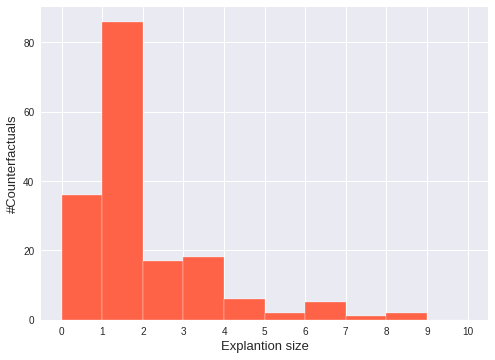

In [12]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(8, 5.76))
plt.hist(cf_size_list, range=(0,10), bins=10, edgecolor='white', color='tomato')
plt.xlabel("Explantion size", fontdict={'fontsize':13})
plt.ylabel("#Counterfactuals", fontdict={'fontsize':13})
plt.xticks([i for i in range(11)])
plt.show()

### Plot counterfactuals

In [10]:
import pickle
# with open('../results/syn1/SGD/syn1_cf_examples_lr0.01_beta0.5_mom0.9_epochs250', 'rb') as file:
with open('../syn5_train.pkl', 'rb') as file:
    results = pickle.load(file)

In [14]:
header = [
    "node_idx",
    "new_idx",
    "cf_adj",
    "sub_adj",
    "y_pred_orig",
    "y_pred_new",
    "y_pred_new_actual",
    "label",
    "num_nodes",
    "loss_total",
    "loss_pred",
    "loss_graph_dist"
]

Pseudocode:

- for new_node_idx in target_nodes_new_indices:
    - if results is not empty:
        - get its 2-hop neighborhood $N$
        - generate nxgraph $G$ from $N$
        - set the same color to all the nodes in $G$
        - set the same color to all the edges in $G$
        - plot the graph in a subplot
        - color cf-edge:
            - green if it is to be added
                - also add the edge $G$
            - red if it is to be deleted
        - plot $G$ in a subplot
        - delete the red cf-edge
        - plot $G$ in a subplot
        - store the image

In [15]:
res = list()
for cf in results:
    if len(cf) != 0:
        res.append({key:val for key, val in zip(header, cf[0])})

In [16]:
target_nodes_indices = [i['node_idx'] for i in res]
target_nodes_new_indices = [i['new_idx'] for i in res]
labels = [i['y_pred_new_actual'] for i in res]

#### cf_dict

In [17]:
cf_dict = dict()
for i in range(len(res)):
    deleted_edges = list()
    rows, cols = np.where(res[i]['sub_adj'] - res[i]['cf_adj'] > 0)
    for row, col in zip(rows, cols):
        # this is done to avoid double counting.
        # the graph is undirected hence every edge will be present twice
        # once at (row, col) and once at (col, row)
        if row < col:
            deleted_edges.append((row, col, 'delete'))
    cf_dict[res[i]['new_idx']] = deleted_edges

In [18]:
cf_dict

{8: [(5, 9, 'delete'), (16, 17, 'delete'), (17, 18, 'delete')],
 6: [(4, 7, 'delete'), (4, 13, 'delete')],
 7: [(4, 6, 'delete'), (16, 17, 'delete'), (16, 21, 'delete')],
 9: [(5, 8, 'delete')],
 15: [(15, 16, 'delete')],
 11: [(11, 12, 'delete')],
 27: [(31, 32, 'delete')],
 13: [(12, 13, 'delete')],
 14: [(13, 14, 'delete')],
 5: [(5, 6, 'delete')],
 23: [(24, 25, 'delete'), (27, 28, 'delete')],
 12: [(12, 13, 'delete')],
 25: [(26, 27, 'delete')],
 19: [(18, 19, 'delete')],
 10: [(10, 11, 'delete')],
 17: [(6, 10, 'delete'),
  (10, 16, 'delete'),
  (10, 17, 'delete'),
  (21, 22, 'delete'),
  (21, 26, 'delete')],
 0: [(0, 2, 'delete')]}

#### Plot

In [17]:
from torch_geometric.utils import k_hop_subgraph, dense_to_sparse, to_dense_adj, subgraph

def get_neighbourhood(node_idx, edge_index, n_hops):
	nodes_in_subgraph, filtered_edge_index, node_mapping ,__ = k_hop_subgraph(
		node_idx, n_hops, edge_index[0], relabel_nodes=True
	)
	sub_adj = to_dense_adj(filtered_edge_index).squeeze()
	new_indices = np.array([i for i in range(len(nodes_in_subgraph))])
	node_dict = dict(zip(nodes_in_subgraph.numpy(), new_indices))
	return sub_adj, node_dict

In [18]:
res[0]

{'node_idx': 161,
 'new_idx': 8,
 'cf_adj': array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

Faulty edge (3, 5). One of the nodes is not part of the 3 neighborhood
Faulty edge (3, 5). One of the nodes is not part of the 3 neighborhood


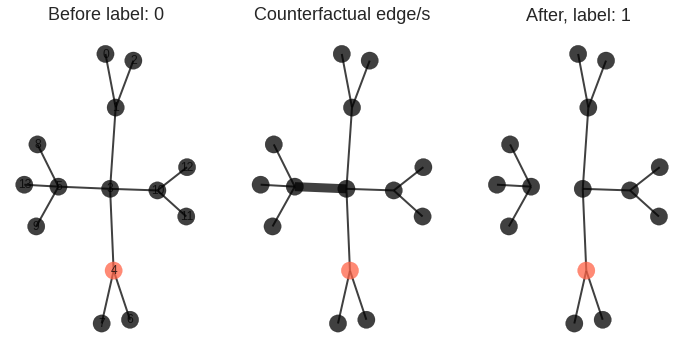

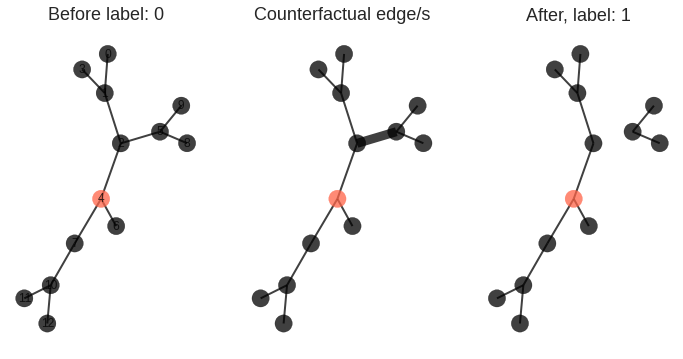

Faulty edge (2, 4). One of the nodes is not part of the 3 neighborhood
Faulty edge (2, 4). One of the nodes is not part of the 3 neighborhood


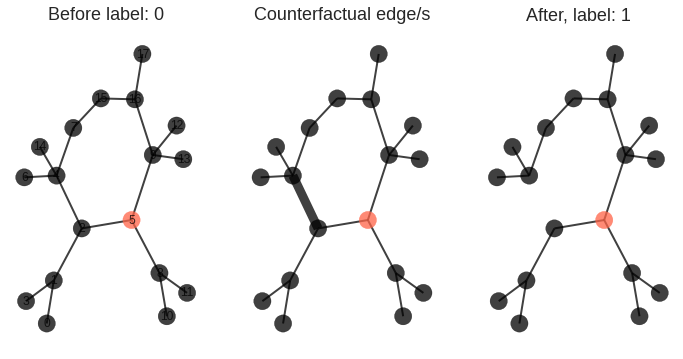

Faulty edge (2, 4). One of the nodes is not part of the 3 neighborhood
Faulty edge (2, 4). One of the nodes is not part of the 3 neighborhood


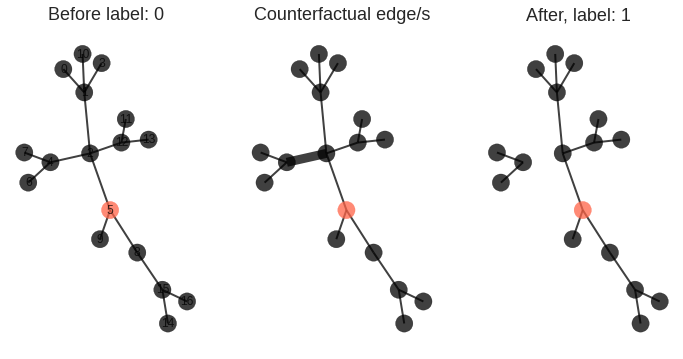

Faulty edge (2, 4). One of the nodes is not part of the 3 neighborhood
Faulty edge (2, 4). One of the nodes is not part of the 3 neighborhood


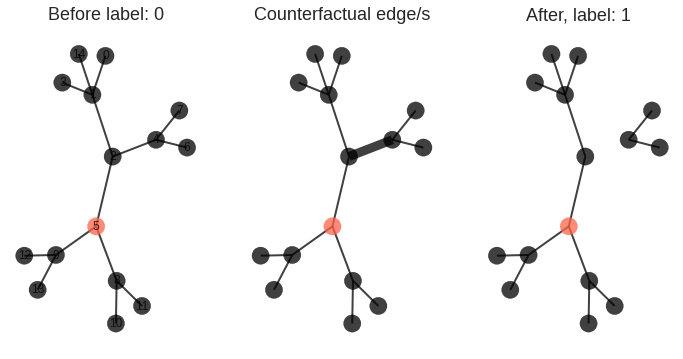

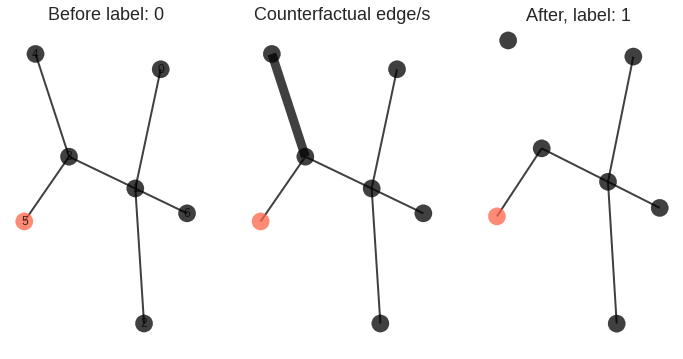

Faulty edge (12, 13). One of the nodes is not part of the 3 neighborhood


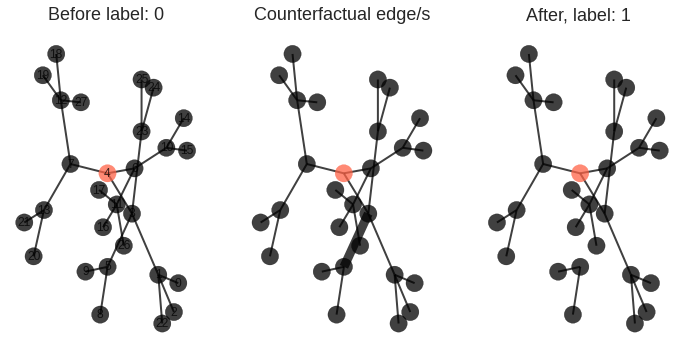

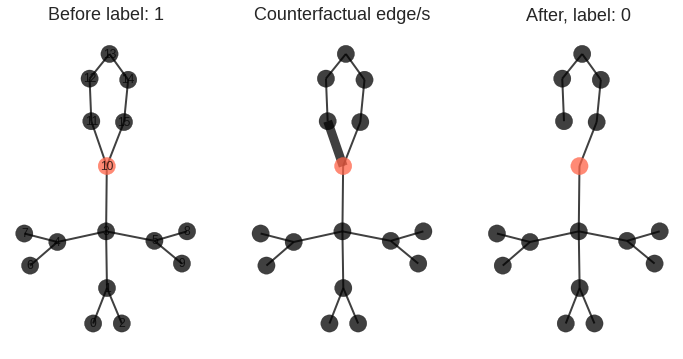

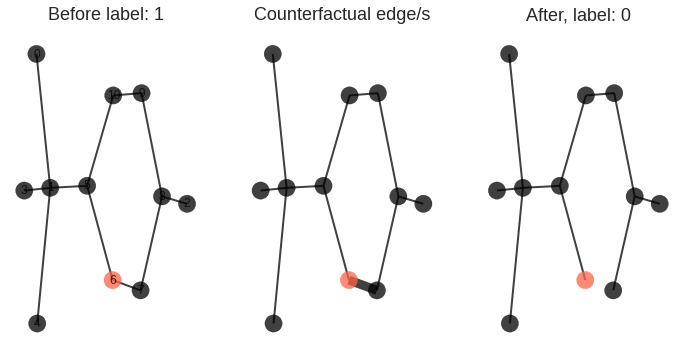

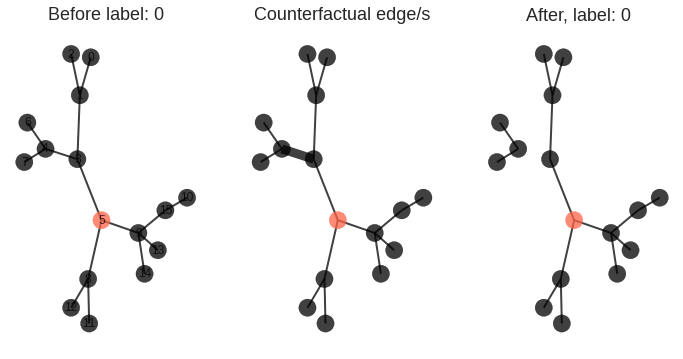

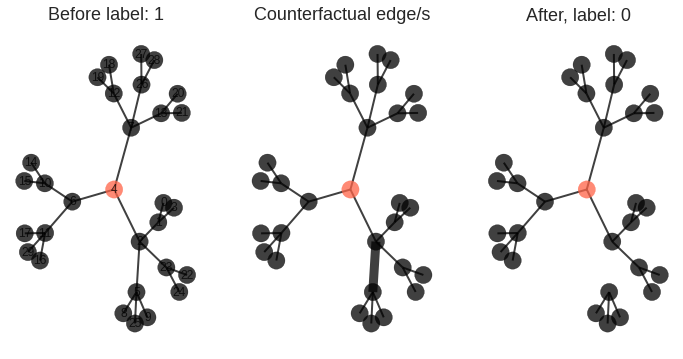

Faulty edge (12, 13). One of the nodes is not part of the 3 neighborhood


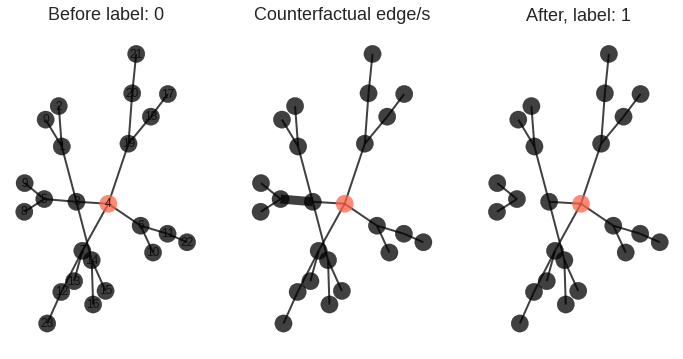

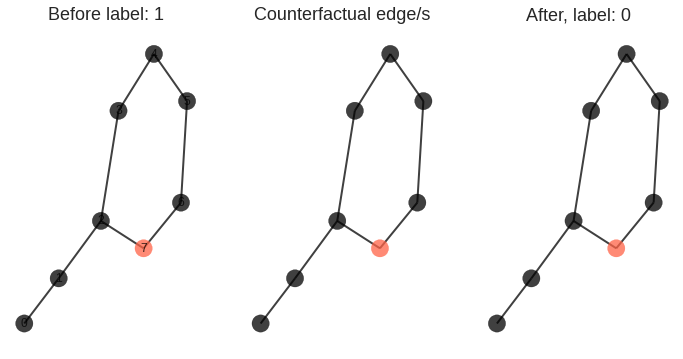

Faulty edge (12, 13). One of the nodes is not part of the 3 neighborhood


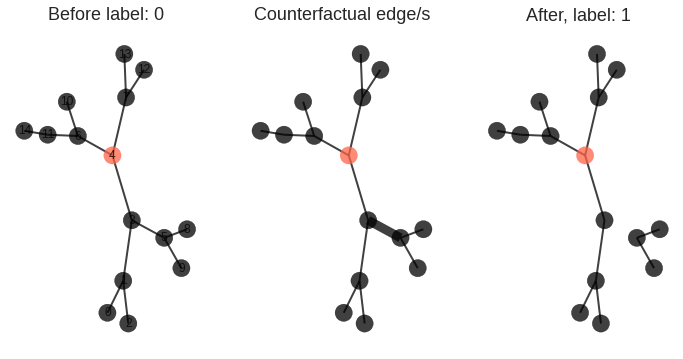

Faulty edge (12, 13). One of the nodes is not part of the 3 neighborhood


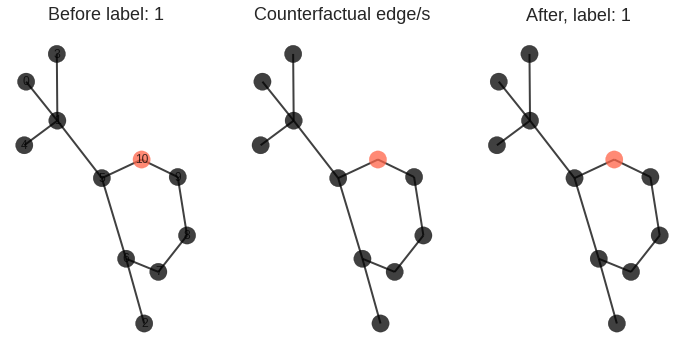

Faulty edge (3, 5). One of the nodes is not part of the 3 neighborhood
Faulty edge (3, 5). One of the nodes is not part of the 3 neighborhood


KeyboardInterrupt: 

In [23]:
from utils.utils import dense_to_sparse
n_hops = 3
for i, node in enumerate(target_nodes_new_indices):
    old_node = target_nodes_indices[i]
    
    edge_index = dense_to_sparse(torch.Tensor(res[i]['sub_adj']))
    neighborhood, node_dict = get_neighbourhood(node, edge_index, n_hops)
    
    # print(neighborhood.size()[0])
    if neighborhood.size()[0] < 1000:
        graph = nx.convert_matrix.from_numpy_array(neighborhood.numpy())
        node_colors = ['black'] * len(graph.nodes)
        node_colors[node_dict[node]] = 'tomato'
        edge_colors = ['black'] * len(graph.edges)
        edge_weights = [2] * len(graph.edges)

        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        # using same pos argument in all graphs is key to having same orientation
        # pos = nx.spring_layout(graph)
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, alpha=0.75, node_color=node_colors, width=edge_weights, with_labels=True)
        plt.title(f"Before label: {res[i]['y_pred_orig']}", fontsize=18)
        # plt.title(f"Before (Label {res[i]['y_pred_orig']})", fontsize=18)

        for edge in cf_dict[node]:
            # nx saves edges of an unordered graph in ascending order of nodes
            # i.e. edge(2,1) is saved as (1,2)
            try:
                u, v = node_dict[edge[0]], node_dict[edge[1]]
            except:
                print(f'Faulty edge {u,v}. One of the nodes is not part of the {n_hops} neighborhood')
                continue
            if u > v:
                u, v = v, u
            if edge[2] == 'add':
                graph.add_edge(u, v)
                # since we have added an edge to the graph we need to make changes to the custom attributes
                edge_colors.append('black')
                edge_weights.append(2)
                edge_colors[list(graph.edges).index((u, v))] = 'green'
                edge_weights[list(graph.edges).index((u, v))] = 9
            else:
                try:
                    # we'll delete this edge later
                    # for some reason this red color isn't rendered
                    edge_colors[list(graph.edges).index((u, v))] = 'red'
                    edge_weights[list(graph.edges).index((u, v))] = 9
                except:
                    pass
        plt.subplot(1,3,2)
        nx.draw(graph, pos=pos, alpha=0.75, edge_color=edge_colors, node_color=node_colors, width=edge_weights)
        plt.title('Counterfactual edge/s', fontsize=18)

        # delete the cf-edge
        for edge in cf_dict[node]:
            try:
                u, v = node_dict[edge[0]], node_dict[edge[1]]
            except:
                pass # same error as before (edge not part of the n_hop neighborhood)
            if u > v:
                u,v = v,u
            if edge[2] == 'delete':
                try:
                    # make changes in the custom attributes
                    edge_colors.pop(list(graph.edges).index((u, v)))
                    edge_weights.pop(list(graph.edges).index((u, v)))
                    graph.remove_edge(u,v)
                except:
                    pass
        plt.subplot(1,3,3)
        # reset custom attributes
        edge_colors = ['black'] * len(graph.edges)
        edge_weights = [2] * len(graph.edges)
        nx.draw(graph, pos=pos, alpha=0.75, width=edge_weights, edge_color=edge_colors, node_color=node_colors)
        nx.spring_layout(graph)
        plt.title(f'After, label: {res[i]["y_pred_new"]}', fontsize=18)
        # plt.title(f'After (Label {res[i]["y_pred_new_actual"]})', fontsize=18)

        # change the following as desired
        plt.savefig(f'../out/cfs/{res[i]["y_pred_orig"]}_node{old_node}.png')
        plt.show()


## Visualize copy

In [ ]:
from utils.utils import dense_to_sparse
n_hops = 2
for i, node in enumerate(target_nodes_new_indices):
    old_node = target_nodes_indices[i]
    
    edge_index = dense_to_sparse(torch.Tensor(res[i]['sub_adj']))
    neighborhood, node_dict = get_neighbourhood(node, edge_index, n_hops)
    
    # print(neighborhood.size()[0])
    if neighborhood.size()[0] < 1000:
        graph = nx.convert_matrix.from_numpy_array(neighborhood.numpy())
        node_colors = ['black'] * len(graph.nodes)
        node_colors[node_dict[node]] = 'tomato'
        edge_colors = ['black'] * len(graph.edges)
        edge_weights = [2] * len(graph.edges)

        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        # using same pos argument in all graphs is key to having same orientation
        # pos = nx.spring_layout(graph)
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, alpha=0.75, node_color=node_colors, width=edge_weights, with_labels=True)
        plt.title(f"Before", fontsize=18)
        # plt.title(f"Before (Label {res[i]['y_pred_orig']})", fontsize=18)

        inter1 = graph.copy()
        for edge in cf_dict[node]:
            # nx saves edges of an unordered graph in ascending order of nodes
            # i.e. edge(2,1) is saved as (1,2)
            try:
                u, v = node_dict[edge[0]], node_dict[edge[1]]
            except:
                print(f'Faulty edge {u,v}. One of the nodes is not part of the {n_hops} neighborhood')
                continue
            if u > v:
                u, v = v, u
            if edge[2] == 'add':
                inter1.add_edge(u, v)
                # since we have added an edge to the graph we need to make changes to the custom attributes
                edge_colors.append('black')
                edge_weights.append(2)
                edge_colors[list(inter1.edges).index((u, v))] = 'green'
                edge_weights[list(inter1.edges).index((u, v))] = 9
            else:
                # we'll delete this edge later
                # for some reason this red color isn't rendered
                edge_colors[list(inter1.edges).index((u, v))] = 'red'
                edge_weights[list(inter1.edges).index((u, v))] = 9
        plt.subplot(1,3,2)
        nx.draw(inter1, pos=pos, alpha=0.75, edge_color=edge_colors, node_color=node_colors, width=edge_weights)
        plt.title('Counterfactual edge/s', fontsize=18)

        inter2 = graph.copy()
        # delete the cf-edge
        for edge in cf_dict[node]:
            try:
                u, v = node_dict[edge[0]], node_dict[edge[1]]
            except:
                pass # same error as before (edge not part of the n_hop neighborhood)
            if u > v:
                u,v = v,u
            if edge[2] == 'delete':
                # make changes in the custom attributes
                edge_colors.pop(list(inter2.edges).index((u, v)))
                edge_weights.pop(list(inter2.edges).index((u, v)))
                graph.remove_edge(u,v)

        plt.subplot(1,3,3)
        # reset custom attributes
        edge_colors = ['black'] * len(graph.edges)
        edge_weights = [2] * len(graph.edges)
        nx.draw(graph, pos=pos, alpha=0.75, width=edge_weights, edge_color=edge_colors, node_color=node_colors)
        nx.spring_layout(graph)
        plt.title('After', fontsize=18)
        # plt.title(f'After (Label {res[i]["y_pred_new_actual"]})', fontsize=18)

        # change the following as desired
        plt.savefig(f'../out/cfs/{res[i]["y_pred_orig"]}_node{old_node}.png')
        plt.show()
